<a href="https://colab.research.google.com/github/Veronikkkka/NLP_fake_news_classifier/blob/main/NLP_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow --upgrade
!pip install ktrain
!pip uninstall -y tensorflow keras
!pip install tensorflow==2.11 keras==2.11

  Using cached tensorflow-2.18.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.1 kB)
  Using cached tensorboard-2.18.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached keras-3.7.0-py3-none-any.whl.metadata (5.8 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-manylinux_2_31_x86_64.whl.metadata (1.1 kB)
Using cached tensorflow-2.18.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (615.3 MB)
Using cached keras-3.7.0-py3-none-any.whl (1.2 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 14.3 MB/s eta 0:00:00
Using cached tensorboard-2.18.0-py3-none-any.whl (5.5 MB)
Using cached tensorboard_data_server-0.7.2-py3-none-manylinux_2_31_x86_64.whl (6.6 MB)
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.6.1
    Uninstalling tensorboard-data-server-0.6.1:
      Successfully uninstalled tensorboard-data-server-0.6.1
  Attempting uninstall: protobuf
    Found existing installatio

In [ ]:
#Імпорти
#Робота з даними
import pandas as pd
import nltk
import os
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import sent_tokenize, word_tokenize
import re
from enum import unique
from textblob import TextBlob
from collections import Counter
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
import numpy as np

#Тренування моделі
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from transformers import BertTokenizer, TFBertModel
import ktrain
from google.colab import drive
import os



from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download("wordnet")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
#Дані
base_path = '/content/drive/MyDrive/'
main_df = pd.read_csv(os.path.join(base_path, 'new_general.csv'))

filtered_df = main_df.dropna(subset=['title', 'text', 'fake'])

start_dataset = main_df.head(5)
print(start_dataset)

# Вибір випадкових рядків з відфільтрованого датафрейму
mini_dataset_len=5000

if len(filtered_df) >= mini_dataset_len:
    mini_dataset = filtered_df.sample(n=mini_dataset_len, random_state=42)
else:
    raise ValueError("У датафреймі недостатньо рядків із заповненими обов'язковими полями для вибірки.")

#print(mini_dataset)

                                               title  \
0  Syria attack symptoms consistent with nerve ag...   
1  Homs governor says U.S. attack caused deaths b...   
2    Death toll from Aleppo bomb attack at least 112   
3        Aleppo bomb blast kills six Syrian state TV   
4  29 Syria Rebels Dead in Fighting for Key Alepp...   

                                                text source  fake  
0  Wed 05 Apr 2017 Syria attack symptoms consiste...    nna     1  
1  Fri 07 Apr 2017 at 0914 Homs governor says U.S...    nna     1  
2  Sun 16 Apr 2017 Death toll from Aleppo bomb at...    nna     1  
3  Wed 19 Apr 2017 Aleppo bomb blast kills six Sy...    nna     1  
4  Sun 10 Jul 2016 29 Syria Rebels Dead in Fighti...    nna     1  


Аналіз (частина Арсенія)

In [ ]:
#Надійність джерела
def calculate_source_reliability(df: pd.DataFrame) -> dict:
    """
    Розраховує відсоток правдивих новин для кожного джерела.
    Повертає словник {джерело: відсоток правдивих новин}.
    """
    if 'source' not in df.columns or 'fake' not in df.columns:
        raise ValueError("Датафрейм повинен мати колонки 'source' і 'fake'")
    reliability = df.groupby('source').apply(
        lambda group: (group['fake'].sum() / len(group)) * 100
    )
    # Повертаємо як словник
    return reliability.to_dict()

def evaluate_source(source: str, reliability_dict: dict) -> float:
    """
    Оцінює надійність конкретного джерела.
    Повертає відсоток правдивих новин для джерела або -1, якщо джерела немає у словнику.
    """
    return reliability_dict.get(source, -1)
#Довжина заголовку
def evaluate_title_length(title: str) -> int:
    """
    Оцінює довжину заголовку.
    Повертає кількість слів у заголовку.
    """
    if not title or not isinstance(title, str):
        return 0
    return len(word_tokenize(title))
#Наявність виразів впевненості
CONFIDENCE_PHRASES = [
    "definitely", "certainly", "without a doubt", "absolutely", "clearly",
    "surely", "undoubtedly", "no doubt", "evidently", "obviously", "sure",
    "positively", "unquestionably"
]
def detect_confidence_phrases(text: str) -> int:
    """
    Перевіряє наявність виразів впевненості у тексті.
    Повертає кількість знайдених виразів.
    """
    if not text or not isinstance(text, str):
        return 0
    tokens = word_tokenize(text.lower())
    confidence_count = sum(1 for token in tokens if token in CONFIDENCE_PHRASES)
    return confidence_count
#Середня довжина речення у тексті
def evaluate_avg_sentence_length(text: str) -> float:
    """
    Оцінює середню довжину речень у тексті.
    Повертає середню кількість слів у реченні.
    """
    if not text or not isinstance(text, str):
        return 0.0
    sentences = sent_tokenize(text)
    if not sentences:
        return 0.0
    word_counts = [len(word_tokenize(sentence)) for sentence in sentences]
    return sum(word_counts) / len(sentences)

In [ ]:
#Перевірка працездатності і Обчислення

mini_dataset['title_length'] = mini_dataset['title'].apply(evaluate_title_length)
mini_dataset['avg_sentence_length'] = mini_dataset['text'].apply(evaluate_avg_sentence_length)
mini_dataset['confidence_presence'] = mini_dataset['text'].apply(detect_confidence_phrases)

true_news = mini_dataset[mini_dataset['fake'] == 1]
fake_news = mini_dataset[mini_dataset['fake'] == 0]

reliability_dictionary = calculate_source_reliability(mini_dataset)

<ipython-input-5-1ef4f6068692>:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  reliability = df.groupby('source').apply(


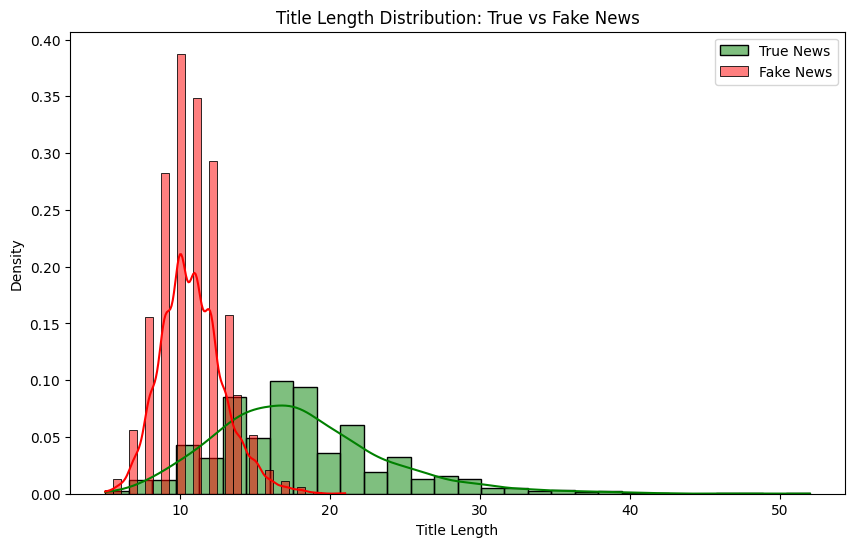

In [ ]:
# 1. Графік для Довжина заголовку
plt.figure(figsize=(10, 6))
sns.histplot(true_news['title_length'], color='green', kde=True, label='True News', stat='density', bins=30)
sns.histplot(fake_news['title_length'], color='red', kde=True, label='Fake News', stat='density', bins=30)
plt.title('Title Length Distribution: True vs Fake News')
plt.xlabel('Title Length')
plt.ylabel('Density')
plt.legend()
plt.show()

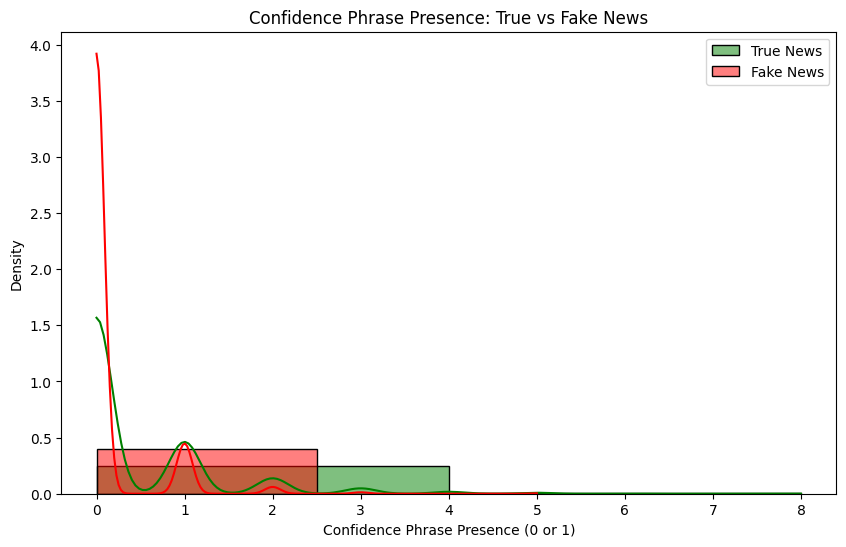

In [ ]:
# 2. Графік для Наявність виразів впевненості
plt.figure(figsize=(10, 6))
sns.histplot(true_news['confidence_presence'], color='green', kde=True, label='True News', stat='density', bins=2)
sns.histplot(fake_news['confidence_presence'], color='red', kde=True, label='Fake News', stat='density', bins=2)
plt.title('Confidence Phrase Presence: True vs Fake News')
plt.xlabel('Confidence Phrase Presence (0 or 1)')
plt.ylabel('Density')
plt.legend()
plt.show()

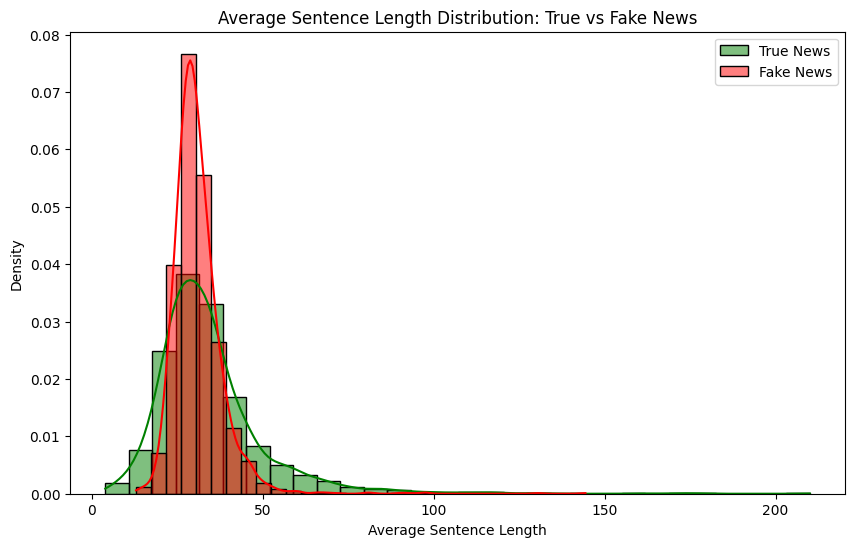

In [ ]:
# 3. Графік для Середня довжина речення
plt.figure(figsize=(10, 6))
sns.histplot(true_news['avg_sentence_length'], color='green', kde=True, label='True News', stat='density', bins=30)
sns.histplot(fake_news['avg_sentence_length'], color='red', kde=True, label='Fake News', stat='density', bins=30)
plt.title('Average Sentence Length Distribution: True vs Fake News')
plt.xlabel('Average Sentence Length')
plt.ylabel('Density')
plt.legend()
plt.show()

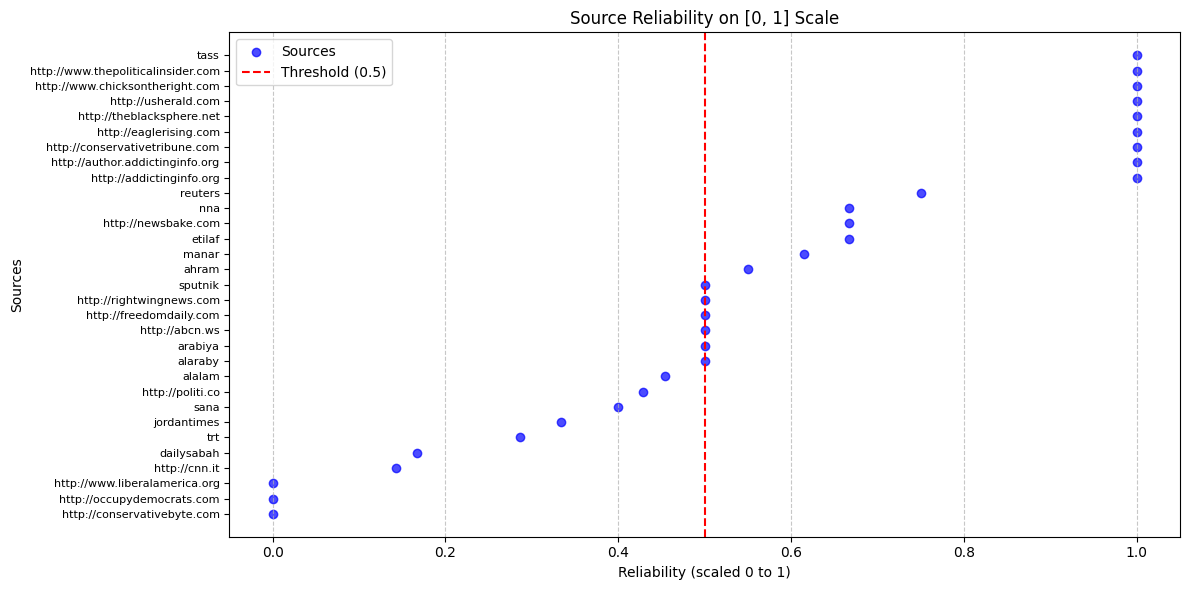

In [ ]:
#4. Графік для Надійності джерел
sorted_reliability = sorted(reliability_dictionary.items(), key=lambda x: x[1])
sources, reliabilities = zip(*sorted_reliability)
reliabilities_scaled = [r / 100 for r in reliabilities]
plt.figure(figsize=(12, 6))
plt.scatter(reliabilities_scaled, range(len(sources)), color='blue', alpha=0.7, label='Sources')
plt.axvline(x=0.5, color='red', linestyle='--', label='Threshold (0.5)')
plt.yticks(range(len(sources)), sources, fontsize=8)
plt.xlabel("Reliability (scaled 0 to 1)")
plt.ylabel("Sources")
plt.title("Source Reliability on [0, 1] Scale")
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Аналіз (частина Ніки)

In [ ]:
def analyze_numbers_in_text(article_text):
    """
    Analyze the use of numbers in a given text and return a score.

    Parameters:
    - article_text (str): The text of the article to analyze.

    Returns:
    - dict: A dictionary containing:
        - 'number_count': Total number of numerical tokens in the text.
        - 'unique_number_count': Count of unique numbers.
        - 'average_number_length': Average length of numerical tokens.
        - 'number_score': A weighted score based on number analysis.
    """
    number_pattern = r'\b\d+(?:\.\d+)?\b'
    numbers = re.findall(number_pattern, article_text)

    number_count = len(numbers)
    # print(numbers)
    unique_numbers = set(numbers)
    unique_number_count = len(unique_numbers)

    average_number_length = (
        sum(len(num) for num in numbers) / number_count if number_count > 0 else 0
    )

    number_score = (
        0.5 * number_count + 0.3 * unique_number_count + 0.2 * average_number_length
    )

    return {
        "number_count": number_count,
        "unique_number_count": unique_number_count,
        "average_number_length": average_number_length,
        "number_score": number_score
    }


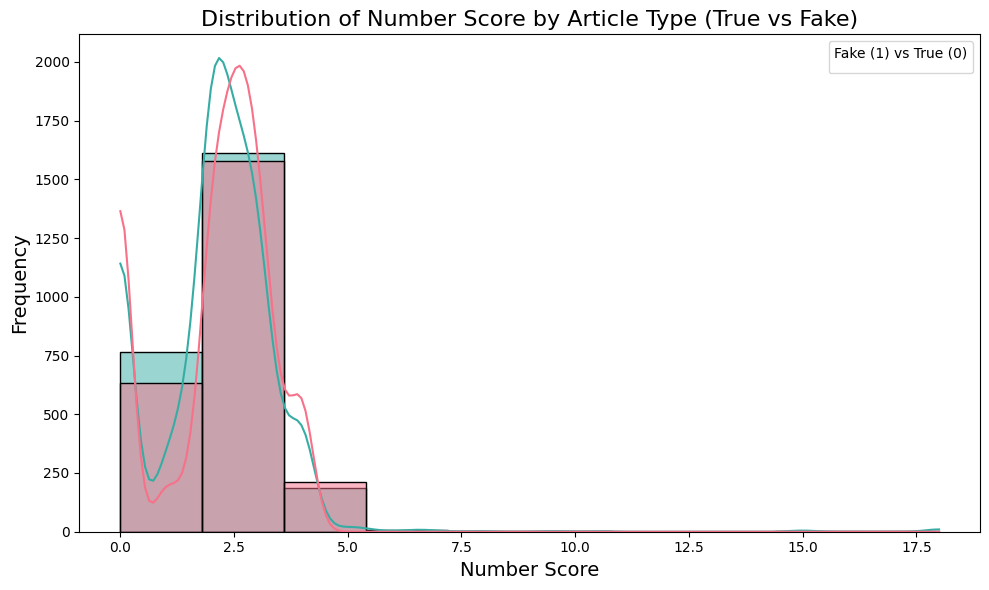

In [ ]:
#Аналіз наявності чисел
mini_dataset["analysis"] = mini_dataset["text"].apply(analyze_numbers_in_text)

mini_dataset["number_count"] = mini_dataset["analysis"].apply(lambda x: x["number_count"])
mini_dataset["unique_number_count"] = mini_dataset["analysis"].apply(lambda x: x["unique_number_count"])
mini_dataset["average_number_length"] = mini_dataset["analysis"].apply(lambda x: x["average_number_length"])
mini_dataset["number_score"] = mini_dataset["analysis"].apply(lambda x: x["number_score"])

comparison = mini_dataset.groupby("fake")[["number_count", "unique_number_count", "average_number_length", "number_score"]].mean()

plt.figure(figsize=(10, 6))
sns.histplot(data=mini_dataset, x="average_number_length", hue="fake", kde=True, bins=10, palette="husl")
plt.title("Distribution of Number Score by Article Type (True vs Fake)", fontsize=16)
plt.xlabel("Number Score", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.legend(title="Fake (1) vs True (0)")
plt.tight_layout()
plt.show()


In [ ]:
def analyze_hyperlinks_in_text(article_text):
    """
    Analyze the presence of hyperlinks in a given text and return a score.

    Parameters:
    - article_text (str): The text of the article to analyze.

    Returns:
    - dict: A dictionary containing:
        - 'hyperlink_count': Total number of hyperlinks in the text.
        - 'unique_hyperlink_count': Count of unique hyperlinks.
        - 'hyperlink_score': A normalized score (0 to 1) based on hyperlink analysis.
    """
    hyperlink_pattern = r'\b(?:http[s]?://|www\.)\S+\b'
    hyperlinks = re.findall(hyperlink_pattern, article_text)

    # Total number of hyperlinks
    hyperlink_count = len(hyperlinks)

    unique_hyperlinks = set(hyperlinks)
    unique_hyperlink_count = len(unique_hyperlinks)

    MAX_HYPERLINK_COUNT = 50  # Assumes a reasonable max count of links in an article
    MAX_UNIQUE_LINK_COUNT = 50  # Assumes a reasonable max unique links in an article

    # Normalized metrics
    # normalized_hyperlink_count = min(hyperlink_count / MAX_HYPERLINK_COUNT, 1.0)
    # normalized_unique_hyperlink_count = min(unique_hyperlink_count / MAX_UNIQUE_LINK_COUNT, 1.0)

    # Weighted score calculation
    hyperlink_score = (
        0.7 * hyperlink_count +
        0.3 * unique_hyperlink_count
    )

    return {
        "hyperlink_count": hyperlink_count,
        "unique_hyperlink_count": unique_hyperlink_count,
        "hyperlink_score": hyperlink_score
    }


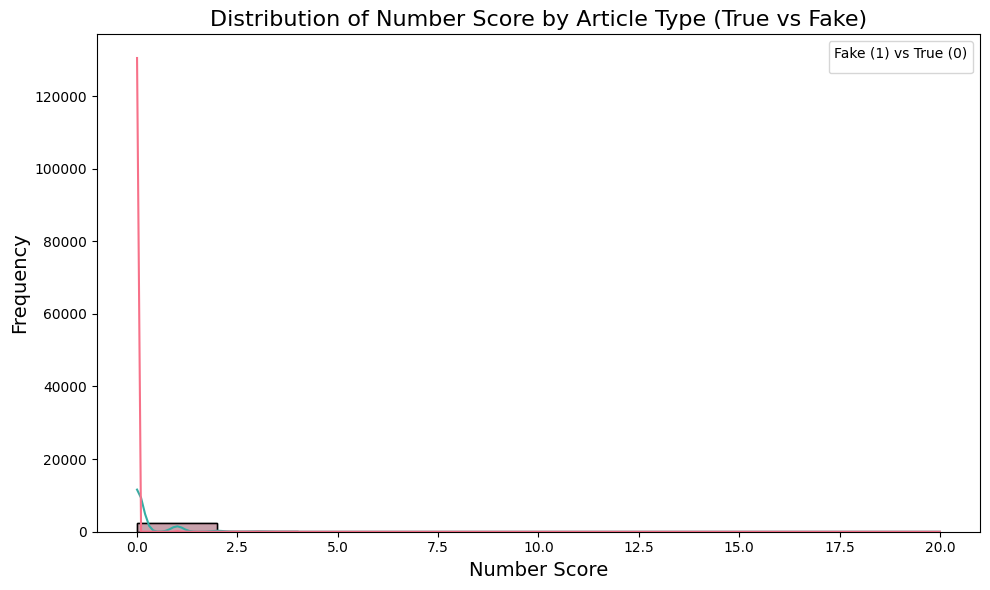

In [ ]:
#Ананліз гіперлінків
mini_dataset["analysis"] = mini_dataset["text"].apply(analyze_hyperlinks_in_text)

mini_dataset["hyperlink_count"] = mini_dataset["analysis"].apply(lambda x: x["hyperlink_count"])
mini_dataset["unique_hyperlink_count"] = mini_dataset["analysis"].apply(lambda x: x["unique_hyperlink_count"])
mini_dataset["hyperlink_score"] = mini_dataset["analysis"].apply(lambda x: x["hyperlink_score"])

comparison = mini_dataset.groupby("fake")[["hyperlink_count", "unique_hyperlink_count", "hyperlink_score"]].mean()

plt.figure(figsize=(10, 6))
sns.histplot(data=mini_dataset, x="unique_hyperlink_count", hue="fake", kde=True, bins=10, palette="husl")
plt.title("Distribution of Number Score by Article Type (True vs Fake)", fontsize=16)
plt.xlabel("Number Score", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.legend(title="Fake (1) vs True (0)")
plt.tight_layout()
plt.show()


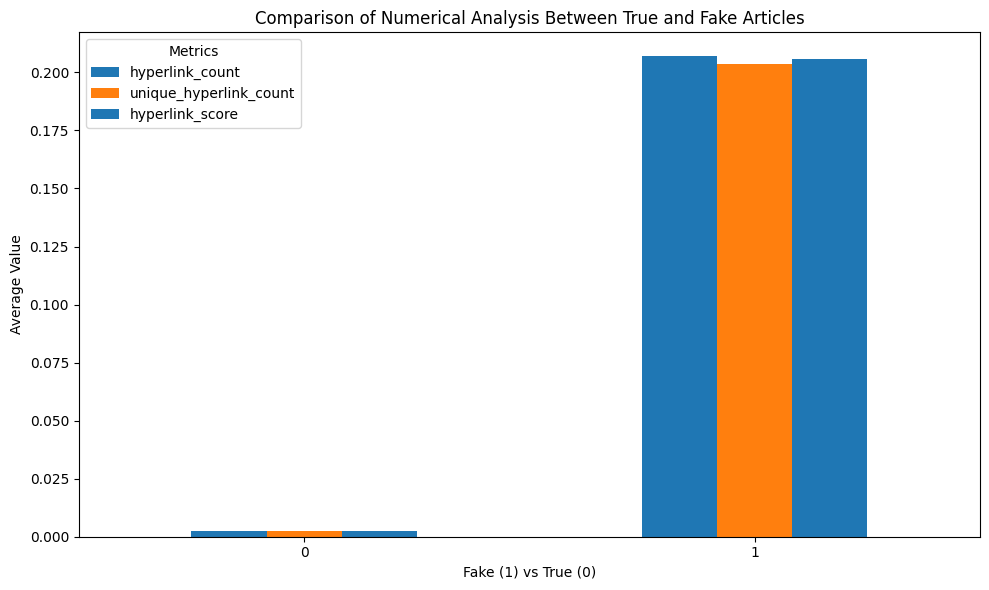

In [ ]:
comparison.plot(kind="bar", figsize=(10, 6), color=["#1f77b4", "#ff7f0e"])
plt.title("Comparison of Numerical Analysis Between True and Fake Articles")
plt.ylabel("Average Value")
plt.xlabel("Fake (1) vs True (0)")
plt.legend(title="Metrics")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
def estimate_emotionality(article_text):
    """
    Estimate the emotionality of a news article.

    Parameters:
    - article_text (str): The text of the article to analyze.

    Returns:
    - dict: A dictionary containing:
        - 'sentiment_polarity': Sentiment polarity (-1 to 1).
        - 'sentiment_subjectivity': Sentiment subjectivity (0 to 1).
        - 'emotion_words_count': Count of words associated with emotions.
        - 'emotionality_score': Normalized score (0 to 1) reflecting emotionality.
    """
    stop_words = set(stopwords.words("english"))
    words = [
        word.lower()
        for word in re.findall(r'\b\w+\b', article_text)
        if word.lower() not in stop_words
    ]

    # Sentiment analysis using TextBlob
    blob = TextBlob(article_text)
    sentiment_polarity = blob.sentiment.polarity
    sentiment_subjectivity = blob.sentiment.subjectivity
    # print(sentiment_subjectivity, type(sentiment_subjectivity))
    emotion_words = {
        "happy", "joy", "sad", "anger", "fear", "love", "hate", "excited",
        "nervous", "calm", "anxious", "worried", "delighted", "cry", "laugh"
    }
    emotion_count = Counter(word for word in words if word in emotion_words)
    emotion_words_count = sum(emotion_count.values())
    # Normalized emotionality score
    # MAX_POLARITY = 1.0  # Maximum absolute polarity
    # MAX_SUBJECTIVITY = 1.0  # Maximum subjectivity
    # MAX_EMOTION_WORDS = 50  # Reasonable max for emotion word count in typical news

    # normalized_polarity = abs(sentiment_polarity) / MAX_POLARITY
    # normalized_subjectivity = sentiment_subjectivity / MAX_SUBJECTIVITY
    # normalized_emotion_words = min(emotion_words_count / MAX_EMOTION_WORDS, 1.0)

    emotionality_score = (
        0.4 * sentiment_polarity +
        0.3 * sentiment_subjectivity +
        0.3 * emotion_words_count
    )

    return {
        "sentiment_polarity": sentiment_polarity,
        "sentiment_subjectivity": sentiment_subjectivity,
        "emotion_words_count": emotion_words_count,
        "emotionality_score": emotionality_score
    }



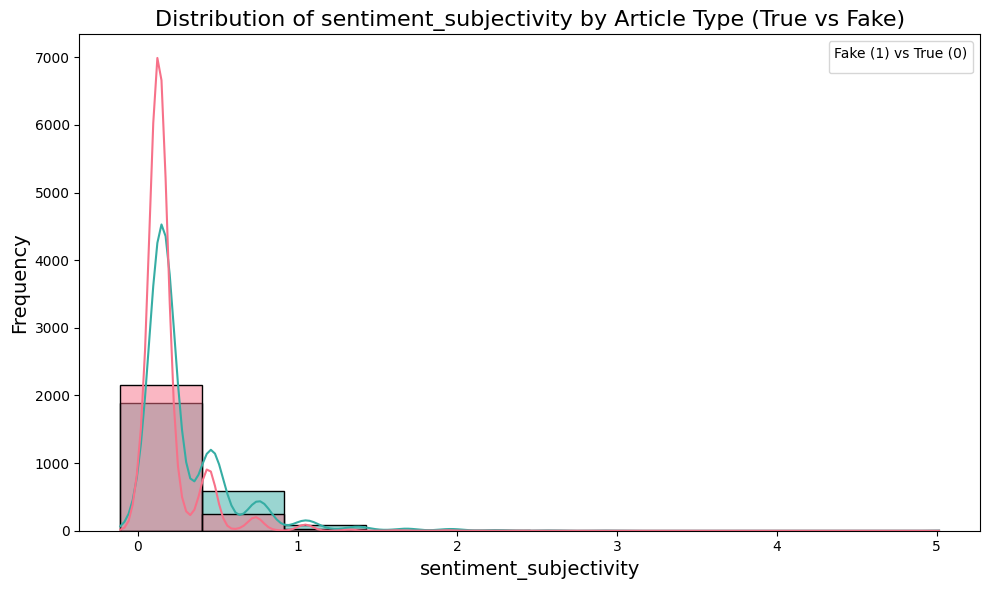

In [ ]:
#Емоційність

mini_dataset["analysis"] = mini_dataset["text"].apply(estimate_emotionality)
mini_dataset["sentiment_polarity"] = mini_dataset["analysis"].apply(lambda x: x["sentiment_polarity"])
mini_dataset["sentiment_subjectivity"] = mini_dataset["analysis"].apply(lambda x: x["sentiment_subjectivity"])
mini_dataset["emotion_words_count"] = mini_dataset["analysis"].apply(lambda x: x["emotion_words_count"])
mini_dataset["emotionality_score"] = mini_dataset["analysis"].apply(lambda x: x["emotionality_score"])

comparison = mini_dataset.groupby("fake")[["sentiment_polarity", "sentiment_subjectivity", "emotion_words_count", "emotionality_score"]].mean()

plt.figure(figsize=(10, 6))
sns.histplot(data=mini_dataset, x="emotionality_score", hue="fake", kde=True, bins=10, palette="husl")
plt.title("Distribution of sentiment_subjectivity by Article Type (True vs Fake)", fontsize=16)
plt.xlabel("sentiment_subjectivity", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.legend(title="Fake (1) vs True (0)")
plt.tight_layout()
plt.show()


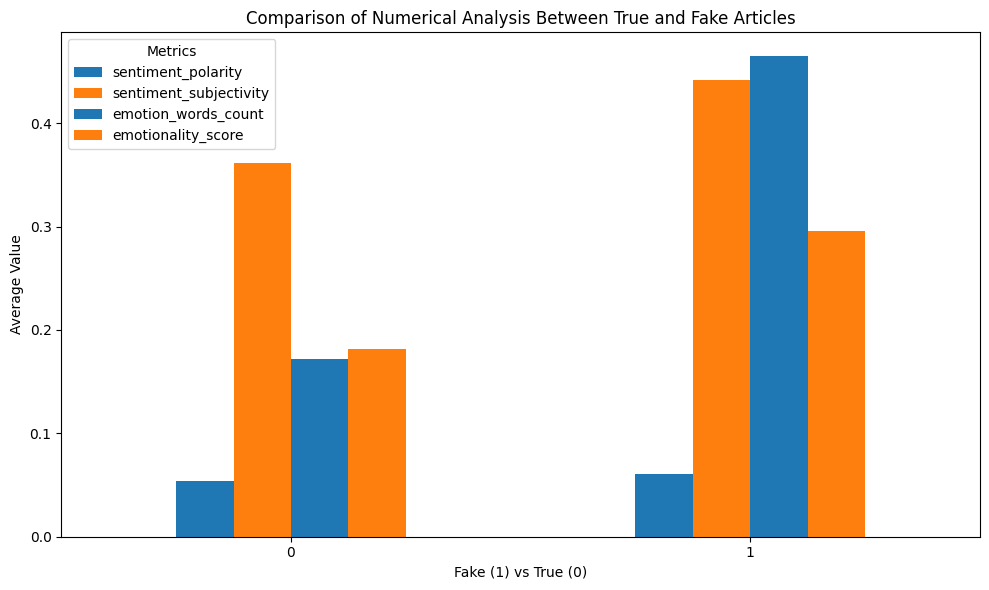

In [ ]:
comparison.plot(kind="bar", figsize=(10, 6), color=["#1f77b4", "#ff7f0e"])
plt.title("Comparison of Numerical Analysis Between True and Fake Articles")
plt.ylabel("Average Value")
plt.xlabel("Fake (1) vs True (0)")
plt.legend(title="Metrics")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
def calculate_source_reliability(df: pd.DataFrame) -> pd.DataFrame:
    """
    Розраховує відсоток правдивих новин для кожного джерела
    та додає новий стовпець 'source_reliability' до датафрейму.
    """
    if 'source' not in df.columns or 'fake' not in df.columns:
        raise ValueError("Датафрейм повинен мати колонки 'source' і 'fake'")

    # Calculate reliability as a percentage of fake news for each source
    reliability = df.groupby('source').apply(
        lambda group: (group['fake'].sum() / len(group)) * 100
    )

    # Map reliability scores back to the original dataframe
    df['source_reliability'] = df['source'].map(reliability)

    return df

Збереження даних з обчислиними параметрами

In [ ]:
base_path = '/content/drive/MyDrive/'
df = pd.read_csv(os.path.join(base_path, 'new_general.csv'))

# Step 2: Apply feature extraction functions and add as new columns
df = calculate_source_reliability(df)
# print(df)
df['title'] = df['title'].fillna('')
df['source'] = df['title'].fillna('')
df['text'] = df['title'].fillna('')

df['combined_text'] = df['title'] + " " + df['source'] + " " + df['text']
df['title_length'] = df['title'].apply(evaluate_title_length)
df['confidence_phrases'] = df["text"].apply(detect_confidence_phrases)
df['numbers_in_text'] = df["text"].apply(analyze_numbers_in_text).apply(lambda x: x["average_number_length"])
df['hyperlinks_in_text'] = df["text"].apply(analyze_hyperlinks_in_text).apply(lambda x: x["hyperlink_score"])
df['emotionality'] = df["text"].apply(estimate_emotionality).apply(lambda x: x["sentiment_polarity"])

df.drop(columns=['title', 'text'], inplace=True)

file_name='dataset_full.csv'
df.to_csv(os.path.join(base_path, file_name), index=False)

<ipython-input-19-be06f57ddf19>:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  reliability = df.groupby('source').apply(


Використання BERT для векторизації тексту

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
def encode_text(texts):
    return tokenizer(texts.tolist(), padding=True, truncation=True, return_tensors='np', max_length=512)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Тренування моделі

In [ ]:
#Завантаження даних. BERT
# Mount Google Drive
drive.mount('/content/drive')

# Set the base path for Google Drive
base_path = '/content/drive/MyDrive/'

# Load the dataset
data = pd.read_csv(os.path.join(base_path, 'dataset_full.csv'))

# BERT: Отримання текстових параметрів
text_parameters=encode_text(data['combined_text'])['input_ids']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Separate numerical features and target
X_numerical = data[['emotionality', 'source_reliability', 'numbers_in_text',
                    'hyperlinks_in_text', 'confidence_phrases', 'title_length']]

y = data['fake']

# Спліт даних (числові + текстові ознаки)
X_train_num, X_test_num, X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_numerical, text_parameters, y, test_size=0.2, random_state=42
)

# Normalize numerical features
scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train_num)
X_test_num_scaled = scaler.transform(X_test_num)

# Convert numerical arrays to NumPy
X_train_num_scaled = np.array(X_train_num_scaled)
X_test_num_scaled = np.array(X_test_num_scaled)

# Перетворення текстових параметрів у NumPy
X_train_text = np.array(X_train_text)
X_test_text = np.array(X_test_text)

# Перевірка на NaN та їх заміна
X_train_num_scaled = np.nan_to_num(X_train_num_scaled)
X_test_num_scaled = np.nan_to_num(X_test_num_scaled)

# Об'єднання числових та текстових ознак
# X_train_combined = np.concatenate([X_train_num_scaled, X_train_text], axis=1)
# X_test_combined = np.concatenate([X_test_num_scaled, X_test_text], axis=1)

X_train_combined = np.concatenate([X_train_num_scaled], axis=1)
X_test_combined = np.concatenate([X_test_num_scaled], axis=1)

# X_train_combined = np.concatenate([ X_train_text], axis=1)
# X_test_combined = np.concatenate([X_test_text], axis=1)

# Define the Keras model architecture
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_combined.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binary classification (0 or 1)
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

# Wrap the Keras model with ktrain's Learner
learner = ktrain.get_learner(model, train_data=(X_train_combined, y_train), val_data=(X_test_combined, y_test))

# Train the model
learner.autofit(epochs=20, lr=0.001)

# Evaluate the model
learner.evaluate()

# Predict on the test set
predictions = learner.model.predict(X_test_combined)

# Print the first 5 predictions
print(predictions[:5])



begin training using triangular learning rate policy with max lr of 0.001...
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/ktrain/__init__.py:138: UserWarning: ktrain currently only supports legacy optimizers in tensorflow>=2.11 - recompiling your model to use legacy Adam
  warnings.warn(


1663/1663 [==============================] - 18s 10ms/step - loss: 0.4765 - accuracy: 0.7552 - val_loss: 0.4420 - val_accuracy: 0.7734
Epoch 2/20
1663/1663 [==============================] - 20s 12ms/step - loss: 0.4565 - accuracy: 0.7669 - val_loss: 0.4409 - val_accuracy: 0.7724
Epoch 3/20
1663/1663 [==============================] - 17s 10ms/step - loss: 0.4537 - accuracy: 0.7670 - val_loss: 0.4409 - val_accuracy: 0.7731
Epoch 4/20
1663/1663 [==============================] - 14s 8ms/step - loss: 0.4530 - accuracy: 0.7687 - val_loss: 0.4400 - val_accuracy: 0.7730
Epoch 5/20
1663/1663 [==============================] - 7s 4ms/step - loss: 0.4527 - accuracy: 0.7688 - val_loss: 0.4398 - val_accuracy: 0.7735
Epoch 6/20
1663/1663 [==============================] - 9s 6ms/step - loss: 0.4517 - accuracy: 0.7690 - val_loss: 0.4402 - val_accuracy: 0.7732
Epoch 7/20
1663/1663 [==============================] - 9s 5ms/step - loss: 0.4505 - accuracy: 0.7698 - val_loss: 0.4399 - val_accuracy: 0.7

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
df = pd.read_csv(os.path.join(base_path, 'dataset_full.csv'))

# 2. Inspect the dataset (uncomment the line below for debugging)
print(df.head())

# Ensure you have columns like 'text' and 'label'
# 'text' contains the news content and 'label' is 0 (fake) or 1 (real)
# assert 'text' in df.columns and 'label' in df.columns

# 3. Preprocess the data
# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df['combined_text'], df['fake'], test_size=0.2, random_state=42
)

# 4. Vectorize text using TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', min_df=5, max_df=0.9)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Convert sparse matrix to a dense array (if dataset is small)
dense_vectors = X_train_tfidf.toarray()

# Get feature names (words corresponding to vector indices)
feature_names = vectorizer.get_feature_names_out()

# Create a dataframe to view the TF-IDF scores
tfidf_dataframe = pd.DataFrame(dense_vectors, columns=feature_names)

# Display the first few rows of the dataframe
print(tfidf_dataframe.head())

# 5. Train a classifier (Random Forest)
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train_tfidf, y_train)

# 6. Evaluate the model
y_pred = classifier.predict(X_test_tfidf)

# Print metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# 7. Save the trained model and vectorizer for future use (optional)
import joblib
joblib.dump(classifier, "fake_news_classifier.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")

print("Model and vectorizer saved as 'fake_news_classifier.pkl' and 'tfidf_vectorizer.pkl'")


                                              source  fake  \
0  Syria attack symptoms consistent with nerve ag...     1   
1  Homs governor says U.S. attack caused deaths b...     1   
2    Death toll from Aleppo bomb attack at least 112     1   
3        Aleppo bomb blast kills six Syrian state TV     1   
4  29 Syria Rebels Dead in Fighting for Key Alepp...     1   

   source_reliability                                      combined_text  \
0           76.923077  Syria attack symptoms consistent with nerve ag...   
1           76.923077  Homs governor says U.S. attack caused deaths b...   
2           76.923077  Death toll from Aleppo bomb attack at least 11...   
3           76.923077  Aleppo bomb blast kills six Syrian state TV Al...   
4           76.923077  29 Syria Rebels Dead in Fighting for Key Alepp...   

   title_length  confidence_phrases  numbers_in_text  hyperlinks_in_text  \
0             9                   0              0.0                 0.0   
1            13   

# Не чіпати не чіпати не чіпати

In [3]:
!pip install tensorflow --upgrade
!pip install ktrain
!pip uninstall -y tensorflow keras
!pip install tensorflow==2.11 keras==2.11
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 36.4 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 66.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 42.3 MB/s eta 0:00:00
  Preparing me

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [4]:
#Імпорти
#Робота з даними
import pandas as pd
import nltk
import os
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import sent_tokenize, word_tokenize
import re
from enum import unique
from textblob import TextBlob
from collections import Counter
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
import numpy as np

#Тренування моделі
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from transformers import BertTokenizer, TFBertModel
import ktrain
from google.colab import drive
import os



from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Завантаження данних

In [5]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset

base_path = '/content/drive/MyDrive/'
df = pd.read_csv(os.path.join(base_path, 'dataset_full.csv'))  # Replace with your actual dataset path

df = df.dropna(subset=['combined_text'])
print(df.head())


                                              source  fake  \
0  Syria attack symptoms consistent with nerve ag...     1   
1  Homs governor says U.S. attack caused deaths b...     1   
2    Death toll from Aleppo bomb attack at least 112     1   
3        Aleppo bomb blast kills six Syrian state TV     1   
4  29 Syria Rebels Dead in Fighting for Key Alepp...     1   

   source_reliability                                      combined_text  \
0           76.923077  Syria attack symptoms consistent with nerve ag...   
1           76.923077  Homs governor says U.S. attack caused deaths b...   
2           76.923077  Death toll from Aleppo bomb attack at least 11...   
3           76.923077  Aleppo bomb blast kills six Syrian state TV Al...   
4           76.923077  29 Syria Rebels Dead in Fighting for Key Alepp...   

   title_length  confidence_phrases  numbers_in_text  hyperlinks_in_text  \
0             9                   0              0.0                 0.0   
1            13   

## Підготовка данних до тренування, розбиття датасету на тренувальні і тестувальні, токенізація

In [6]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from datasets import Dataset
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df[['combined_text', 'fake']], test_size=0.2, random_state=42)

train_dataset = Dataset.from_pandas(train_data)
test_dataset = Dataset.from_pandas(test_data)

# from transformers import AlbertTokenizer, AlbertForSequenceClassification

# tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
# model = AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=2)


model_name = "prajjwal1/bert-tiny"  # назва моделі, маленький берт
tokenizer = AutoTokenizer.from_pretrained(model_name)
# завантаження претренованої моделі
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

def tokenize_function(examples):
    return tokenizer(examples['combined_text'], padding="max_length", truncation=True, max_length=256)

# токенізація
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

train_dataset = train_dataset.rename_column('fake', 'labels').rename_column('combined_text', 'text')
test_dataset = test_dataset.rename_column('fake', 'labels').rename_column('combined_text', 'text')

train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

Map:   0%|          | 0/53204 [00:00<?, ? examples/s]

Map:   0%|          | 0/13302 [00:00<?, ? examples/s]

In [7]:
! pip install evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.7 MB/s eta 0:00:00


In [8]:
import evaluate

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    return accuracy.compute(predictions=predictions, references=labels)

In [9]:
from transformers import TrainerCallback

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    report_to="none",
    save_strategy="no",
    metric_for_best_model="eval_accuracy",
)


class SaveBestModelCallback(TrainerCallback):
    def __init__(self, metric_name="eval_accuracy", mode="max"):
        """
        Callback to save the best model based on a specific metric.

        Args:
            metric_name (str): Metric to track, e.g., "eval_accuracy", "eval_loss".
            mode (str): "min" for metrics like loss, "max" for metrics like accuracy.
        """
        self.metric_name = metric_name
        self.mode = mode
        self.best_metric = float("inf") if mode == "min" else -float("inf")
        self.best_model_dir = "./best_model"

    def on_evaluate(self, args, state, control, metrics, **kwargs):
        metric_value = metrics.get(self.metric_name)
        if metric_value is not None:
            is_better = (
                metric_value < self.best_metric if self.mode == "min" else metric_value > self.best_metric
            )
            if is_better:
                self.best_metric = metric_value
                kwargs["model"].save_pretrained(self.best_model_dir)
                print(f"Best model saved with {self.metric_name}: {self.best_metric}")


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    callbacks=[SaveBestModelCallback(metric_name="eval_accuracy", mode="max")],
)


# finetuning
trainer.train()


{'loss': 0.6978, 'grad_norm': 2.556020975112915, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.0015035333032626672}
{'loss': 0.6981, 'grad_norm': 3.006281614303589, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.0030070666065253344}
{'loss': 0.7134, 'grad_norm': 5.240856647491455, 'learning_rate': 3e-06, 'epoch': 0.0045105999097880016}
{'loss': 0.7096, 'grad_norm': 1.5922991037368774, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.006014133213050669}
{'loss': 0.701, 'grad_norm': 3.288558006286621, 'learning_rate': 5e-06, 'epoch': 0.007517666516313336}
{'loss': 0.6947, 'grad_norm': 2.200091600418091, 'learning_rate': 6e-06, 'epoch': 0.009021199819576003}
{'loss': 0.7171, 'grad_norm': 3.818019390106201, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.010524733122838671}
{'loss': 0.7014, 'grad_norm': 2.3838000297546387, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.012028266426101338}
{'loss': 0.7071, 'grad_norm': 1.747722864151001, 'learning_rate': 9e-06, 'epoch': 

KeyError: "The `metric_for_best_model` training argument is set to 'eval_accuracy', which is not found in the evaluation metrics. The available evaluation metrics are: ['eval_loss', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'epoch']. Consider changing the `metric_for_best_model` via the TrainingArguments."

In [ ]:
# Evaluate the model
results = trainer.evaluate()
print(results)

In [ ]:
test_data.head()
test_dataset
predictions = trainer.predict(test_dataset)

logits = predictions.predictions
labels = predictions.label_ids

predicted_classes = logits.argmax(axis=-1)

accuracy = (predicted_classes == labels).mean()

In [ ]:
import os
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np
import spacy

small_df = df[:5000]
train_docs, test_docs, Y_train, Y_test = train_test_split(small_df['combined_text'], small_df['fake'], test_size=0.2, random_state=111)

def token_to_int_feats(nlp, token):
    features = [
        token.is_alpha,
        token.is_digit,
        token.is_punct,
        token.is_space,
        len(token),
        ord(token.text[0]),
        nlp.vocab.strings[token.text] if token.text in nlp.vocab.strings else 0
    ]
    return [int(f) for f in features]



In [ ]:
!pip install spacy
!python -m spacy download en_core_web_sm


In [ ]:
import pandas as pd
import numpy as np
import spacy
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

nlp = spacy.load("en_core_web_sm")

def token_to_int_feats5(nlp, t):
    doc = nlp(t)
    features = {
        "pos": doc[0].pos_ if len(doc) > 0 else "",
        "lemma": doc[0].lemma_ if len(doc) > 0 else "",
        "is_stop": doc[0].is_stop,
        "dep": doc[0].dep_ if len(doc) > 0 else "",
        "is_alpha": doc[0].is_alpha,
        "is_digit": doc[0].is_digit,
        "right_context_hash": hash(doc[-1].text) % 10**6 if len(doc) > 1 else 0
    }

    int_features = {
        "pos": nlp.vocab.strings[features["pos"]],
        "lemma": nlp.vocab.strings[features["lemma"]],
        "is_stop": int(features["is_stop"]),
        "dep": nlp.vocab.strings[features["dep"]],
        "is_alpha": int(features["is_alpha"]),
        "is_digit": int(features["is_digit"]),
        "right_context_hash": features["right_context_hash"]
    }
    return list(int_features.values())

class TextToFeaturesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, nlp):
        self.nlp = nlp

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.array([token_to_int_feats5(self.nlp, text) for text in X])

# df = pd.read_csv("your_data.csv")

X = df[['combined_text', 'title_length', 'confidence_phrases', 'numbers_in_text', 'hyperlinks_in_text', 'emotionality']]
Y = df['fake']

numeric_features = ['title_length', 'confidence_phrases', 'numbers_in_text', 'hyperlinks_in_text', 'emotionality']
text_feature = 'combined_text'

preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(stop_words='english', max_features=5000), text_feature),
        ('num', StandardScaler(), numeric_features)  # Scale numeric features
    ])

clf = make_pipeline(preprocessor, LogisticRegression(random_state=111, max_iter=1000))

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=111)

clf.fit(X_train, y_train)

print(f"Training Accuracy: {clf.score(X_train, y_train)}")
print(f"Test Accuracy: {clf.score(X_test, y_test)}")

param_grid = {
    'logisticregression__C': [0.1, 1, 10],
    'logisticregression__solver': ['liblinear', 'lbfgs'],
}

# Жадібний пошук  гіпер-параметрів
grid_search = GridSearchCV(clf, param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best training score: {grid_search.best_score_}")


In [ ]:
clf.score(X_test, y_test)

In [ ]:
len(X_train_raw)
X_train

In [ ]:
# !pip uninstall -y tensorflow keras
# !pip install tensorflow keras tf_keras

# !pip install ktrain

In [ ]:
import pandas as pd
import os
# os.environ['TF_USE_LEGACY_KERAS'] = "1"
from ktrain import text
from sklearn.model_selection import train_test_split

# Load the dataset
df = pd.read_csv(os.path.join(base_path, 'dataset_full.csv'))
print(df.head())
# Ensure we have the necessary columns
assert 'combined_text' in df.columns and 'fake' in df.columns

# Convert text and labels to lists (to ensure compatibility)
# X = df['combined_text'].tolist()
# y = df['fake'].tolist()

# X_train, X_test, y_train, y_test = train_test_split(df['combined_text'], y, test_size=0.2, random_state=42)
# X_train = df['combined_text'][:int(0.8*len(df))]
# X_test = df['combined_text'][int(0.8*len(df)):]
df['combined_text'] = df['combined_text'].astype(str).str.strip()
df = df[df['combined_text'].str.len() > 0]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    df['combined_text'], df['fake'],
    test_size=0.2, random_state=42
)
# Check the data type to ensure it's a list
print(f"Type of X_train: {type(X_train)}")
# print(f"Type of y_train: {type(y_train)}")
print(X_train[:5])

# Step 2: Preprocess the text data with ktrain
# Choose a preprocessor for text classification
preprocessor = text.Transformer('distilbert-base-uncased', maxlen=512, class_names=['real', 'fake'])

# Preprocess training and test data
train_data = preprocessor.preprocess_train(X_train.tolist(), y_train.tolist())
test_data = preprocessor.preprocess_test(X_test.tolist(), y_test.tolist())



In [ ]:
# Create the model using ktrain
model = preprocessor.get_model()

# Create a learner object
learner = ktrain.get_learner(model, train_data=train_data, val_data=test_data, batch_size=16)

# Train the model using fit_onecycle (you can adjust the learning rate)
learner.fit_onecycle(2e-5, 5)  # Learning rate: 2e-5, Train for 5 epochs


In [ ]:
X = data[['emotionality', 'source_reliability', 'numbers_in_text',
          'hyperlinks_in_text', 'confidence_phrases', 'title_length']]
y = data['fake']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to NumPy arrays explicitly (to ensure compatibility)
import numpy as np
X_train_scaled = np.array(X_train_scaled)
X_test_scaled = np.array(X_test_scaled)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Define the Keras model architecture
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binary classification (0 or 1)
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Wrap the Keras model with ktrain's Learner
learner = ktrain.get_learner(model, train_data=(X_train_scaled, y_train), val_data=(X_test_scaled, y_test))

# Train the model using autofit (no epochs argument)
learner.autofit(epochs=10, lr=0.1)

# Evaluate the model
learner.evaluate()

# Predict on the test set
predictions = learner.predict(X_test_scaled)

# Print the first 5 predictions
print(predictions[:5])